In [183]:

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pydicom
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
from IPython.display import update_display
from subprocess import Popen
PATH = "/mnt/d/CBIS-DDSM/"
roipath = PATH + "new_ROI/"
save = roipath + 'resize_with_padding/'
# malignant_roi_path = PATH + "ROI/malignant/"
# fullimg_benign_path = PATH + "fullimg/benign/"
# fullimg_malignant_path = PATH + "fullimg/malignant/"

img_height=300
img_width=300




In [184]:
# for dirName, subdirList, fileList in os.walk(imgPATH):
    # for fname in fileList:
        # if fname.endswith('.dcm'):
            # dcm_path = dirName+'/'+fname
            # img_path = dirName+'/'+fname.replace('.dcm','.png')
            # Popen(['convert',dcm_path,img_path]).wait()

In [185]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.2),fill_mode='reflect'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='reflect'),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='reflect')
  ])

2023-03-04 23:11:21.602854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 23:11:21.622516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-04 23:11:21.623516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-04 23:11:21.623559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

In [186]:
calc_train = pd.read_csv(PATH + "csv/calc_case_description_train_set.csv")
mass_train = pd.read_csv(PATH + "csv/mass_case_description_train_set.csv")
calc_train = calc_train[['patient_id','left or right breast','image view','pathology','calc type','ROI mask file path']]
mass_train = mass_train[['patient_id','left or right breast','image view','pathology','mass shape','cropped image file path']]
information = pd.read_csv(PATH + "csv/dicom_info.csv")
information = information[['image_path','PatientID','SeriesDescription','SeriesInstanceUID']]
cropped_information = information.loc[information['SeriesDescription']=='cropped images']
ROI_mask_information = information.loc[information['SeriesDescription']=='ROI mask images']


In [187]:
train_benign = np.empty((1,6), dtype=object)
val_benign = np.empty((1,6), dtype=object)
train_malignant = np.empty((1,6), dtype=object)
val_malignant = np.empty((1,6), dtype=object)
# benign_calc = calc_train.loc[calc_train['pathology']=='BENIGN']
# benign_calc =  benign_calc.groupby(['calc type'])
# rng = np.random.default_rng(seed=42)
# arrays = {}
# for name, group in benign_calc:
    # arrays[name] = np.array(group)
# for name, array in arrays.items():
    # for paths in array[:]:
        # paths[5] = paths[5].split('/')[-2]
    # if len(array) >3:
        # array = rng.permutation(array)
        # train_benign = np.concatenate((train_benign,array[:int(0.8*len(array))]))
        # val_benign = np.concatenate((val_benign,array[int(0.8*len(array)):]))
    # else:
        # train_benign = np.concatenate((train_benign,array))
# malignant_calc = calc_train.loc[calc_train['pathology']=='MALIGNANT']
# malignant_calc =  malignant_calc.groupby(['calc type'])
# rng = np.random.default_rng(seed=42)
# arrays = {}
# for name, group in malignant_calc:
    # arrays[name] = np.array(group)
# for name, array in arrays.items():
    # for paths in array[:]:
        # paths[5] = paths[5].split('/')[-2]
    # if len(array) >3:
        # array = rng.permutation(array)
        # train_malignant = np.concatenate((train_malignant,array[:int(0.8*len(array))]))
        # val_malignant = np.concatenate((val_malignant,array[int(0.8*len(array)):]))
    # else:
        # train_malignant = np.concatenate((train_malignant,array))
benign_mass = mass_train.loc[mass_train['pathology']=='BENIGN']
benign_mass =  benign_mass.groupby(['mass shape'])
rng = np.random.default_rng(seed=42)
arrays = {}
for name, group in benign_mass:
    arrays[name] = np.array(group)
for name, array in arrays.items():
    for paths in array[:]:
        paths[5] = paths[5].split('/')[-2]
    if len(array) >3:
        array = rng.permutation(array)
        train_benign = np.concatenate((train_benign,array[:int(0.8*len(array))]))
        val_benign = np.concatenate((val_benign,array[int(0.8*len(array)):]))
    else:
        train_benign = np.concatenate((train_benign,array))
malignant_mass = mass_train.loc[mass_train['pathology']=='MALIGNANT']
malignant_mass =  malignant_mass.groupby(['mass shape'])
rng = np.random.default_rng(seed=43)
arrays = {}
for name, group in malignant_mass:
    arrays[name] = np.array(group)
for name, array in arrays.items():
    for paths in array[:]:
        paths[5] = paths[5].split('/')[-2]
    if len(array) >3:
        array = rng.permutation(array)
        train_malignant = np.concatenate((train_malignant,array[:int(0.8*len(array))]))
        val_malignant = np.concatenate((val_malignant,array[int(0.8*len(array)):]))
    else:
        train_malignant = np.concatenate((train_malignant,array))
train_benign = train_benign[1:]
val_benign = val_benign[1:]
train_malignant = train_malignant[1:]
val_malignant = val_malignant[1:]

/tmp/ipykernel_310/2832916809.py:39: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in benign_mass:
/tmp/ipykernel_310/2832916809.py:54: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in malignant_mass:


In [188]:
ignore_id = []
for dirName, subdirList, fileList in os.walk(roipath+'Need_Revise/'):
    for fname in fileList:
        if fname.endswith('.png'):
            ignore_id.append('_'.join(fname.split('.')[0].split('_')[:-1]))
print(ignore_id)

['Mass-Test_P_00639_LEFT_MLO_1', 'Mass-Test_P_01254_RIGHT_CC_1', 'Mass-Test_P_00194_RIGHT_MLO_1', 'Mass-Test_P_00598_LEFT_CC_1', 'Mass-Test_P_00962_RIGHT_CC_1', 'Mass-Test_P_00962_RIGHT_MLO_1', 'Mass-Test_P_01348_LEFT_MLO_1', 'Mass-Test_P_01546_LEFT_MLO_1', 'Calc-Training_P_00260_RIGHT_MLO_1', 'Calc-Training_P_00276_RIGHT_CC_1', 'Calc-Training_P_00291_LEFT_CC_1', 'Calc-Training_P_00291_LEFT_CC_2', 'Calc-Training_P_00302_LEFT_CC_2', 'Calc-Training_P_00302_LEFT_MLO_1', 'Calc-Training_P_00302_LEFT_MLO_2', 'Calc-Training_P_00311_RIGHT_CC_1', 'Calc-Training_P_00395_RIGHT_CC_3', 'Calc-Training_P_00395_RIGHT_MLO_1', 'Calc-Training_P_00425_RIGHT_CC_1', 'Calc-Training_P_00425_RIGHT_MLO_1', 'Calc-Training_P_00491_LEFT_MLO_1', 'Calc-Training_P_00642_LEFT_CC_1', 'Calc-Training_P_00647_RIGHT_CC_1', 'Calc-Training_P_00647_RIGHT_MLO_1', 'Calc-Training_P_00669_RIGHT_CC_1', 'Calc-Training_P_00761_RIGHT_MLO_1', 'Calc-Training_P_00909_LEFT_MLO_1', 'Calc-Training_P_01102_LEFT_CC_1', 'Calc-Training_P_01170

In [189]:
calc_test = pd.read_csv(PATH + "csv/calc_case_description_test_set.csv")
mass_test = pd.read_csv(PATH + "csv/mass_case_description_test_set.csv")
calc_test = calc_test[['patient_id','left or right breast','image view','pathology','calc type','ROI mask file path']]
mass_test = mass_test[['patient_id','left or right breast','image view','pathology','mass shape','cropped image file path']]
test_benign = np.empty((1,6), dtype=object)
test_malignant = np.empty((1,6), dtype=object)
for i in range(len(mass_test)):
    test = mass_test.iloc[i].to_numpy()
    test[5] = test[5].split('/')[-2]
    if test[3] == 'BENIGN':
        test_benign = np.concatenate((test_benign,[test]))
    elif test[3] == 'MALIGNANT':
         test_malignant = np.concatenate((test_malignant,[test]))
# for i in range(len(calc_test)):
    # test = calc_test.iloc[i].to_numpy()
    # test[5] = test[5].split('/')[-2]
    # if test[3] == 'BENIGN':
        # test_benign = np.concatenate((test_benign,[test]))
    # elif test[3] == 'MALIGNANT':
        # test_malignant = np.concatenate((test_malignant,[test]))
test_benign = test_benign[1:]
test_malignant = test_malignant[1:]

In [190]:
test_benign[:,5]

array(['1.3.6.1.4.1.9590.100.1.2.199593071810497070809647901570077988031',
       '1.3.6.1.4.1.9590.100.1.2.44610919611642954332266410812181604922',
       '1.3.6.1.4.1.9590.100.1.2.94222899611000951402700588920137869763',
       '1.3.6.1.4.1.9590.100.1.2.33104460512287295106729517150165977308',
       '1.3.6.1.4.1.9590.100.1.2.110953826510138522735661961202537426056',
       '1.3.6.1.4.1.9590.100.1.2.276507869711889466025221201043664468321',
       '1.3.6.1.4.1.9590.100.1.2.134608828413047482619420299572009428223',
       '1.3.6.1.4.1.9590.100.1.2.180919249412973969916092916872198534127',
       '1.3.6.1.4.1.9590.100.1.2.116879083712206295028137553270209945564',
       '1.3.6.1.4.1.9590.100.1.2.423283243012912888204847591923699853302',
       '1.3.6.1.4.1.9590.100.1.2.273736527812245924738896549683395645939',
       '1.3.6.1.4.1.9590.100.1.2.68262587513622730932485303632746993994',
       '1.3.6.1.4.1.9590.100.1.2.302117799111020717142633394451378732071',
       '1.3.6.1.4.1.9590.100.

# Functions

In [191]:
from typing import io, Union, Any, List, Tuple
# @detect_func_err
def binarize(img: np.ndarray, thresh: str = 'otsu', threshval: int = 1) -> np.ndarray:
    """
    Función utilizada retornar una máscara a partir de una imagen de entrada
    :param img: imagen a binarizar
    :param threshval: Valor de threshold. Todos aquellos valores inferiores al threshold se asignarán a 0. (negro)
    :param thresh: Tipo de binarización a realizar. Las opciones validas son otsu o constant.
    :return: imagen binarizada.
    """

    # Primero se aplica un filtro adaptativo para crear una binarización por thresholding
    if thresh == 'otsu':
        return cv2.threshold(img, threshval, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    elif thresh == 'constant':
        return cv2.threshold(img, threshval, 255, cv2.THRESH_BINARY)[1]
    else:
        raise ValueError(f'Thresholding method {thresh} not implemented')


# @detect_func_err
def edit_mask(mask: np.ndarray, operations: List[tuple] = None, kernel_size: tuple = (23, 23),
              kernel_shape: int = cv2.MORPH_ELLIPSE) -> np.ndarray:
    """
    Función para modificar una máscara aplicando filtros morfologicos.
    :param mask: mascara a modificar
    :param kernel_size: tamaño del kernel para aplicar los filtros morfológicos
    :param kernel_shape: forma del filtro
    :param operations: lista de tuplas cuyo primer elemento es la operación morfológica a aplicar y la segunda el número
                       de veces a aplicar la transformación
    :return: mascara modificada
    """

    # Se genera el kernel para realizar la transformación morgológica de la imagen.
    if operations is None:
        operations = [(cv2.MORPH_OPEN, 1),(cv2.MORPH_DILATE,1)]

    kernel = cv2.getStructuringElement(shape=kernel_shape, ksize=kernel_size)

    # Se realiza una erosión seguida de una dilatación para eliminar el ruido situado en el fondo de la imagen
    # a la vez que posible ruido alrededor del pecho.
    for (transformation, iters) in operations:
        cv2.morphologyEx(mask, transformation, kernel, iterations=iters, dst=mask)

    return mask


# @detect_func_err
def get_breast_zone(mask: np.ndarray, convex_contour: bool = False) -> Union[np.ndarray, tuple]:

    """
    Función de obtener la zona del seno de una imagen a partir del area mayor contenido en una mascara.
    :param mask: mascara sobre la cual se realizará la búsqueda de contornos y de las zonas más largas.
    :param convex_contour: boleano para aplicar contornos convexos.
    :return: Máscara que contiene el contorno con mayor area juntamente con el vértice x e y con la anchura y la altura
             del cuadrado que contienen la zona de mayor area de la mascara-
    """

    # Se obtienen los contornos de las zonas de la imagen de color blanco.
    contours =cv2.findContours(image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)[0]

    # Se obtiene el contorno más grande a partir del area que contiene
    largest_countour = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    # Se modifican los contornos si se decide obtener contornos convexos.
    if convex_contour:
        largest_countour = cv2.convexHull(largest_countour)

    # Se crea la máscara con el area y el contorno obtenidos.
    breast_zone = cv2.drawContours(
        image=np.zeros(mask.shape, np.uint8), contours=[largest_countour], contourIdx=-1, color=(255, 255, 255),
        thickness=-1
    )

    # Se obtiene el rectangulo que contiene el pecho
    x, y, w, h = cv2.boundingRect(largest_countour)

    return breast_zone, (x, y, w, h)


# @detect_func_err
def remove_artifacts(image: np.ndarray, mask: np.ndarray = None, crop: bool = True, **kwargs) \
        -> Tuple[Any, np.ndarray, Any, Any]:
    """
    Función con el pipeline utilizado para remover los artefactos de una imágen mamográfica y obtener exclusivamente
    la zona del seno
    :param img: imágen con los artefactos
    :param mask: másara de cada imagen con el ROI. Se aplicarán las mismas modificaciones que a la imagen original
    :param crop: booleano para recortar la zona del seno de cada imagen
    :param kwargs: parámetrizaciones para cada función del pipeline
    :return: imagen original sin artefactos, mascara del seno, mascara sin artefactos, mascara del roi modificada
    """
    img = image.copy()
    if mask is None:
        mask = np.zeros(img.shape,dtype=np.uint8)

    bin_mask = binarize(img=img, **kwargs.get('bin_kwargs', {}))
    modified_mask = edit_mask(mask=bin_mask, **kwargs.get('mask_kwargs', {}))
    breast_mask, (x, y, w, h) = get_breast_zone(mask=modified_mask, **kwargs.get('contour_kwargs', {}))
    img[breast_mask == 0] = 0

    if crop:
        return img[y:y + h, x:x + w], modified_mask, breast_mask[y:y + h, x:x + w], mask[y:y + h, x:x + w]
    else:
        return img, modified_mask, breast_mask, mask

In [196]:
def remove_artefact(data):
    border_y = int(0.05*data.shape[0])
    border_x = int(0*data.shape[1])
    rect = cv2.rectangle(img=np.zeros((data.shape),dtype='uint8'),pt1=(border_x,border_y),pt2=(data.shape[1]-border_x, data.shape[0]-border_y),color=(255,255,255),thickness=-1)
    data = cv2.bitwise_and(data,data,mask=rect)
    contours,_= cv2.findContours(data,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    contour_placeholder = np.zeros((data.shape),np.uint8())
    largest_contour = max(contours,key=cv2.contourArea)
    contour_mask = cv2.drawContours(contour_placeholder,[largest_contour],contourIdx=0,color=(255,255,255),thickness=-1)
    data = cv2.bitwise_and(data,data,mask=contour_mask)
    canny = cv2.Canny(data,50,150,apertureSize=3)
    canny[:,0]=1
    canny[:,data.shape[1]-1]=1
    contour, _ = cv2.findContours(canny,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    canny_mask = cv2.drawContours(np.ones((data.shape),np.uint8()),contour,contourIdx=-1,color=(0,0,0),thickness=-1)
    data = cv2.bitwise_and(data,data,mask=canny_mask)
    return data
def bounding_box(data,image_pad=10):
    '''
    '''
    
    ret,thresh = cv2.threshold(data,127,255,0)
    contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    largest_contours = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(largest_contours)
    # x_mid = x+w/2
    # y_mid = y+h/2
    x-=image_pad
    y-=image_pad
    w += 2*image_pad
    h += 2*image_pad
    if x+w > data.shape[1]: x = data.shape[1] - w
    elif x<0: x=0
    if y+h > data.shape[0]: y = data.shape[0] - h
    elif y<0: y=0
    # if w > 300 or h > 300:
        # if w > h: r = w/2
        # elif h > w: r = h/2
        # else: r=w
    # else: r = 300
    # if x_mid + r > data.shape[1]: x_mid = data.shape[1]-r
    # elif x_mid - r < 0: x_mid = r
    # if y_mid + r > data.shape[0]: y_mid = data.shape[0]-r
    # elif y_mid - r < 0: y_mid = r
    # return int(x_mid),int(y_mid),int(r)
    # ,int(w),int(h)
    return x,y,w,h

def GCN(img):
    img_mean = np.mean(img)
    img_std = np.std(img)
    img = (img - img_mean)/img_std 

    # Scale the image to the range [0, 255]
    img = ((img - np.min(img)) * 255 / (np.max(img) - np.min(img))).astype(np.uint8)
    return img
def process_image(file_path,mask_file,category=False,file_save=False,image_pad=10,augment=False):
    data = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    data = remove_artefact(data)
    # ret,thresh = cv2.threshold(data,1,255,0)
    # contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # if contours:
        # largest_contours = max(contours, key=cv2.contourArea)
        # x,y,w,h = cv2.boundingRect(largest_contours)
        # if w>50 and h>50:
            # data = data[y:y+h,x:x+w]
    # ret,thresh = cv2.threshold(data,254,255,0)
    # contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # if contours:
        # largest_contours = max(contours, key=cv2.contourArea)
        # x,y,w,h = cv2.boundingRect(largest_contours)
        # if w< data.shape[1]/2:
            # if x+w == data.shape[1]:
                # data = data[:,:data.shape[1]-w]
            # elif x == 0:
                # data = data[:,w:]
        # if h< data.shape[0]/2:
            # if y+h == data.shape[0]:
                # data = data[:data.shape[1]-h,:]
            # elif y == 0:
                # data = data[h:,:]
    data = cv2.medianBlur(data,7)
    data = clahe.apply(data)
    # data = cv2.medianBlur(data,3)
    # data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    data = GCN(data)
    # data, modified_mask, breast_mask, mask = remove_artifacts(data,None,False)
    # data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    mask_file = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    x,y,w,h = bounding_box(mask_file,image_pad)
    if w<300 and h<300:
        placeholder = np.zeros((img_width,img_height),dtype=np.uint8)
        data = data[y:y+h,x:x+w]
        data = clahe2.apply(data)
        placeholder[int(img_height/2-h/2):int(img_height/2+h/2),int(img_width/2-w/2):int(img_width/2+w/2)] = data
        img = placeholder
    else:
        if w > h:
            y=int(y-(w-h)/2)
            h=w
        elif h>w:
            x=int(x-(h-w)/2)
            w=h
        if x+w > data.shape[1]: x = data.shape[1] - w
        elif x<0: x=0
        if y+h > data.shape[0]: y = data.shape[0] - h
        elif y<0: y=0
        data = data[y:y+h,x:x+w]
        data = clahe2.apply(data)
        img=cv2.resize(data,(img_width,img_height))
    
    # x,y,w,h= bounding_box(mask_file,image_pad=50)
    # data = data[y:y+h,x:x+w]
    # data = GCN(data)
    # img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    
    # img=cv2.resize(data,(img_width,img_height))
    if file_save != False and category !=False:
        save_path = str(save)+str(category)+str(file_save)
        print(save_path) 
        directory= str(save)+str(category)
        if not os.path.exists(directory):
            os.makedirs(directory)
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        cv2.imwrite(save_path+'_1.png',img)
        if augment:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
            cv2.imwrite(save_path+'_2.png',img)
            img = cv2.rotate(img, cv2.ROTATE_180)
            cv2.imwrite(save_path+'_3.png',img)
            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            cv2.imwrite(save_path+'_4.png',img)
        # for i in range(augment):
            # img2 = data_augmentation(img)    
            # cv2.imwrite(save_path+'_'+str(i+2)+'.png',img2.numpy())
    return img

In [193]:
full_information = information.loc[information['SeriesDescription']=='full mammogram images']
# print(list(full_information.index.values))
for i in list(full_information.index.values):
    # print(full_information.loc[i,'PatientID'])
    id = full_information.loc[i,'PatientID']
    # print(id)
    if id.endswith('.dcm'):
        full_information.at[i,'PatientID'] = id.split('.')[0]
        print(id)
    else:
        full_information.at[i,'PatientID'] = '_'.join(id.split('_')[1:])
# full_information.at[1,'PatientID'] = 0

# full_information

In [208]:
ignore_id =[]
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(16,8))
clahe2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(1,1))

In [209]:
for i in range(len(ROI_mask_information)):
    info = ROI_mask_information.iloc[i]
    augment=False
    if info['SeriesInstanceUID'] in val_benign:
        mamogram_category = 'val/benign/'
        # augment = True
    elif info['SeriesInstanceUID'] in val_malignant:
        mamogram_category = 'val/malignant/'
        # augment = True
    elif info['SeriesInstanceUID'] in train_benign:
        mamogram_category = 'train/benign/'
        # augment = True
    elif info['SeriesInstanceUID'] in train_malignant:
        mamogram_category = 'train/malignant/'
        # augment=True
    elif info['SeriesInstanceUID'] in test_benign:
        mamogram_category = 'test/benign/'
    elif info['SeriesInstanceUID'] in test_malignant:
        mamogram_category = 'test/malignant/'
    else:
        mamogram_category = "unknown"
    mask_path = '/mnt/d/' + str(info['image_path'])
    # print(info['PatientID'] + ' ' + mamogram_category)
    full_img_info = full_information.loc[full_information['PatientID'] == '_'.join(info['PatientID'].split('_')[1:-1])].to_numpy()
    if (info['PatientID'] not in ignore_id):
        if np.any(full_img_info) != False and mamogram_category!='unknown':
            full_img_path = '/mnt/d/' + str(full_img_info[0,0])
            process_image(full_img_path,mask_path,mamogram_category,str(info['PatientID']),image_pad=10,augment=augment)
            # print(full_img_info[0,0])
    else:
        print(str(info['PatientID']) + ' needs to be revised')

/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/train/benign/Mass-Training_P_00242_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/val/malignant/Mass-Training_P_00634_RIGHT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/test/benign/Mass-Test_P_00882_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/train/malignant/Mass-Training_P_00241_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/train/benign/Mass-Training_P_00348_LEFT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/train/malignant/Mass-Training_P_00259_RIGHT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/train/malignant/Mass-Training_P_00248_LEFT_MLO_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/test/benign/Mass-Test_P_00391_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/test/benign/Mass-Test_P_01257_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/train/benign/Mass-Training_P_00569_RIGHT_CC_1
/mnt/d/CBIS-DDSM/new_ROI/resize_with_padding/test/benign/Mass-Test_P_00391_LEFT_MLO_1
/mnt/d/

# Fix images


# Testing

In [9]:
def GCN(img):
    img_mean = np.mean(img)
    img_std = np.std(img)
    img = (img - img_mean) / img_std

    # Scale the image to the range [0, 255]
    img = ((img - np.min(img)) * 255 / (np.max(img) - np.min(img))).astype(np.uint8)
    return img

In [22]:
def normalize_breast(img: np.ndarray, mask: np.ndarray = None, type_norm: str = 'min_max') -> np.ndarray:
    """
    Función para normalizar una imagen teniendo en cuenta exclusivamente los valores presentes en una mascara.
    Existen dos tipos de normalizaciones (min_max o truncation).
    :param img: Imagen a normalizar
    :param mask: Masara de las zonas de la imagen a tenen en cuenta para normalizar
    :param type_norm: Tipo de normalización. Los valores aceptados son.
                      - min_max = se realiza un escalado min_max
                      - truncation = se realiza un escalado por truncado utilizando el percentil 99 y percentil 10 de
                                     los píxeles de cada imagen
    :return: imagen normalizada
    """

    # Se transforma la imagen a float para no perder informacion
    img_float = img.copy().astype(float)

    # En caso de no existir mascara se utilizará toda la imagen
    if mask is None:
        mask = np.ones(img.shape)

    # Normalización min, max
    if type_norm == 'min_max':
        min_ = img_float[mask != 0].min()
        max_ = img_float[mask != 0].max()

    # normalización por truncado
    elif type_norm == 'truncation':
        min_ = np.percentile(img_float[mask != 0], 10)
        max_ = np.percentile(img_float[mask != 0], 99)

    else:
        raise ValueError(f'{type_norm} not implemented in normalize_breast')

    # Se asigna el valor 255 como máximo de la normalización
    img_norm = ((np.clip(img_float, min_, max_) - min_) / (max_ - min_)) * 255
    img_norm[mask == 0] = 0

    return np.uint8(img_norm)

In [49]:
from typing import io, Union, Any, List, Tuple
# @detect_func_err
def binarize(img: np.ndarray, thresh: str = 'otsu', threshval: int = 1) -> np.ndarray:
    """
    Función utilizada retornar una máscara a partir de una imagen de entrada
    :param img: imagen a binarizar
    :param threshval: Valor de threshold. Todos aquellos valores inferiores al threshold se asignarán a 0. (negro)
    :param thresh: Tipo de binarización a realizar. Las opciones validas son otsu o constant.
    :return: imagen binarizada.
    """

    # Primero se aplica un filtro adaptativo para crear una binarización por thresholding
    if thresh == 'otsu':
        return cv2.threshold(img, threshval, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    elif thresh == 'constant':
        return cv2.threshold(img, threshval, 255, cv2.THRESH_BINARY)[1]
    else:
        raise ValueError(f'Thresholding method {thresh} not implemented')


# @detect_func_err
def edit_mask(mask: np.ndarray, operations: List[tuple] = None, kernel_size: tuple = (23, 23),
              kernel_shape: int = cv2.MORPH_ELLIPSE) -> np.ndarray:
    """
    Función para modificar una máscara aplicando filtros morfologicos.
    :param mask: mascara a modificar
    :param kernel_size: tamaño del kernel para aplicar los filtros morfológicos
    :param kernel_shape: forma del filtro
    :param operations: lista de tuplas cuyo primer elemento es la operación morfológica a aplicar y la segunda el número
                       de veces a aplicar la transformación
    :return: mascara modificada
    """

    # Se genera el kernel para realizar la transformación morgológica de la imagen.
    if operations is None:
        operations = [(cv2.MORPH_OPEN, 1)]

    kernel = cv2.getStructuringElement(shape=kernel_shape, ksize=kernel_size)

    # Se realiza una erosión seguida de una dilatación para eliminar el ruido situado en el fondo de la imagen
    # a la vez que posible ruido alrededor del pecho.
    for (transformation, iters) in operations:
        cv2.morphologyEx(mask, transformation, kernel, iterations=iters, dst=mask)

    return mask


# @detect_func_err
def get_breast_zone(mask: np.ndarray, convex_contour: bool = False) -> Union[np.ndarray, tuple]:

    """
    Función de obtener la zona del seno de una imagen a partir del area mayor contenido en una mascara.
    :param mask: mascara sobre la cual se realizará la búsqueda de contornos y de las zonas más largas.
    :param convex_contour: boleano para aplicar contornos convexos.
    :return: Máscara que contiene el contorno con mayor area juntamente con el vértice x e y con la anchura y la altura
             del cuadrado que contienen la zona de mayor area de la mascara-
    """

    # Se obtienen los contornos de las zonas de la imagen de color blanco.
    contours =cv2.findContours(image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)[0]

    # Se obtiene el contorno más grande a partir del area que contiene
    largest_countour = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    # Se modifican los contornos si se decide obtener contornos convexos.
    if convex_contour:
        largest_countour = cv2.convexHull(largest_countour)

    # Se crea la máscara con el area y el contorno obtenidos.
    breast_zone = cv2.drawContours(
        image=np.zeros(mask.shape, np.uint8), contours=[largest_countour], contourIdx=-1, color=(255, 255, 255),
        thickness=-1
    )

    # Se obtiene el rectangulo que contiene el pecho
    x, y, w, h = cv2.boundingRect(largest_countour)

    return breast_zone, (x, y, w, h)


# @detect_func_err
def remove_artifacts(image: np.ndarray, mask: np.ndarray = None, crop: bool = True, **kwargs) \
        -> Tuple[Any, np.ndarray, Any, Any]:
    """
    Función con el pipeline utilizado para remover los artefactos de una imágen mamográfica y obtener exclusivamente
    la zona del seno
    :param img: imágen con los artefactos
    :param mask: másara de cada imagen con el ROI. Se aplicarán las mismas modificaciones que a la imagen original
    :param crop: booleano para recortar la zona del seno de cada imagen
    :param kwargs: parámetrizaciones para cada función del pipeline
    :return: imagen original sin artefactos, mascara del seno, mascara sin artefactos, mascara del roi modificada
    """
    img = image.copy()
    if mask is None:
        mask = np.zeros(img.shape)

    bin_mask = binarize(img=img, **kwargs.get('bin_kwargs', {}))
    modified_mask = edit_mask(mask=bin_mask, **kwargs.get('mask_kwargs', {}))
    breast_mask, (x, y, w, h) = get_breast_zone(mask=modified_mask, **kwargs.get('contour_kwargs', {}))
    img[breast_mask == 0] = 0

    if crop:
        return img[y:y + h, x:x + w], modified_mask, breast_mask[y:y + h, x:x + w], mask[y:y + h, x:x + w]
    else:
        return img, modified_mask, breast_mask, mask

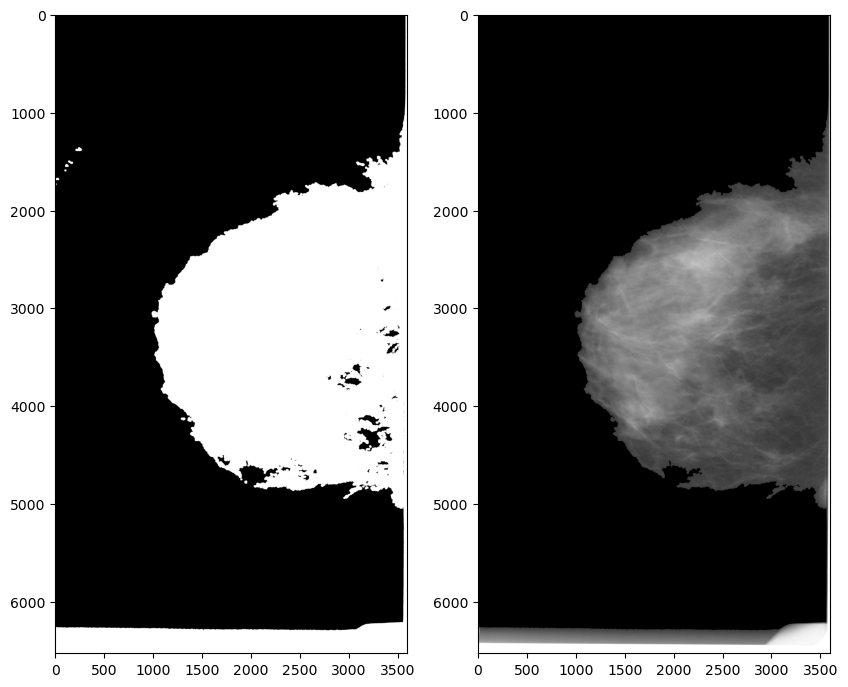

In [50]:
mask = cv2.imread('/mnt/d/Datasets/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Mass-Training_P_00076_LEFT_CC_1/07-21-2016-DDSM-NA-20119/1.000000-ROI mask images-13422/1-2.png',cv2.IMREAD_GRAYSCALE)
data = cv2.imread('/mnt/c/Users/user/Desktop/CBIS-DDSM/full/train/benign/Mass-Training_P_00076_LEFT_CC.png',cv2.IMREAD_GRAYSCALE)
img, modified_mask, breast_mask, mask = remove_artifacts(data,None,False)
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(modified_mask,cmap='gray')
plt.subplot(122)
plt.imshow(img,cmap='gray')

Calc-Test_P_01414_RIGHT_CC

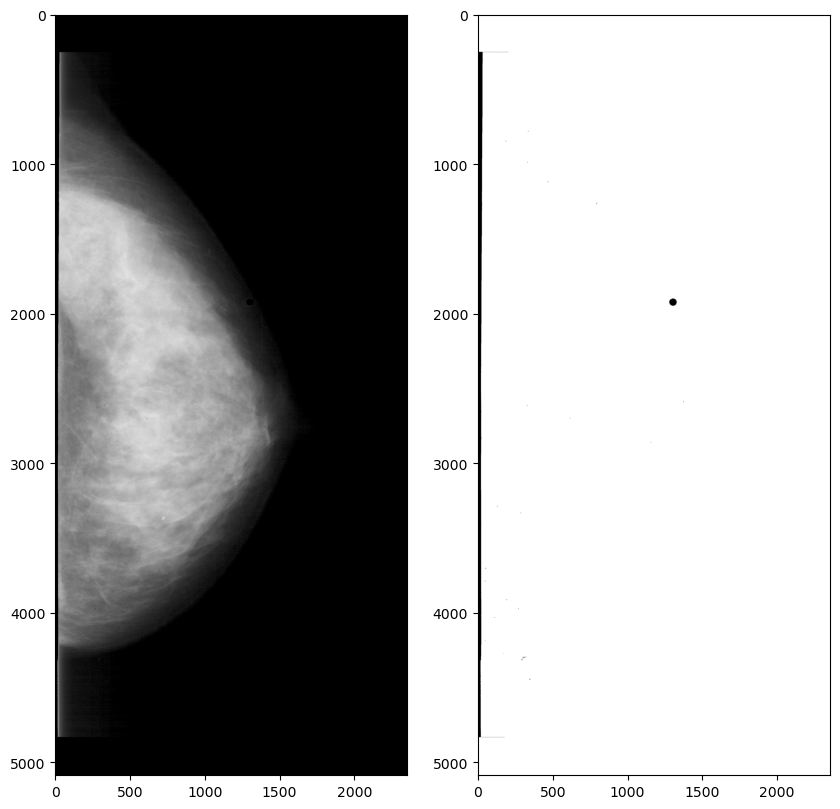

In [207]:
mask = cv2.imread('/mnt/d/Datasets/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_01414_RIGHT_CC_1/08-29-2017-DDSM-NA-40350/1.000000-ROI mask images-67640/1-2.png',cv2.IMREAD_GRAYSCALE)
data = cv2.imread('/mnt/c/Users/user/Desktop/CBIS-DDSM/full/test/benign/Calc-Test_P_01414_RIGHT_CC.png',cv2.IMREAD_GRAYSCALE)
# img, modified_mask, breast_mask, mask = remove_artifacts(data,mask,False)

border_y = int(0.05*data.shape[0])
border_x = int(0*data.shape[1])
rect = cv2.rectangle(img=np.zeros((data.shape),dtype='uint8'),pt1=(border_x,border_y),pt2=(data.shape[1]-border_x, data.shape[0]-border_y),color=(255,255,255),thickness=-1)
data = cv2.bitwise_and(data,data,mask=rect)
contours,_= cv2.findContours(data,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
contour_placeholder = np.zeros((data.shape),np.uint8())
largest_contour = max(contours,key=cv2.contourArea)
contour_mask = cv2.drawContours(contour_placeholder,[largest_contour],contourIdx=0,color=(255,255,255),thickness=-1)
data = cv2.bitwise_and(data,data,mask=contour_mask)
canny = cv2.Canny(data,50,150,apertureSize=3)
canny[:,0]=1
canny[:,data.shape[1]-1]=1
contour, _ = cv2.findContours(canny,mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
canny_mask = cv2.drawContours(np.ones((data.shape),np.uint8()),contour,contourIdx=-1,color=(0,0,0),thickness=-1)
data = cv2.bitwise_and(data,data,mask=canny_mask)


plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(data,cmap='gray')
plt.subplot(122)
plt.imshow(canny_mask,cmap='gray')

In [148]:
for line in houghline:
    rho, theta = line[0]
    print("rho: {:.2f}, theta: {:.2f}".format(rho, theta))

rho: 20.00, theta: 0.00
rho: 29.00, theta: 0.00
rho: 17.00, theta: 0.00
rho: 26.00, theta: 0.00
rho: 1.00, theta: 0.00
rho: 94.00, theta: 0.02


20 1000
29 1000
17 1000
26 1000
1 1000
76 1001
-28 -999
23 1000
74 1001
-30 -999
33 1000
-1000 253
-1000 4831
41 1000
53 1001
-53 -999
17 1000
43 1000
-42 -999
25 1000
36 1000
-65 -999
-83 -998
28 1000
-79 -998
133 1005
-77 -998
-2 1000
-45 -999
-1084 4811
191 1011
49 1001
-53 -998
-67 -998
72 1001
-995 272
-13 -999
-37 -999
62 1001
67 1001
81 1001
1 -1000
-2 -1000
-11 -999
-16 -999
-20 -999
-50 -999
55 1001
60 1001
-1004 233
4 -1000
-5 -1000
-9 -999
-59 -999
-69 -998
-6 1000
-23 -999
-33 -999
7 -1000
-915 4850
-71 -998
-5 1001
87 1003
-112 -996
-5 1000
85 1003
-150 -995
248 1019
-93 -996
84 1001
-183 -994
-125 -996
-8 1000
-87 -996
-106 -996
-171 -994
-85 -996
16 1002
-13 1001
-90 -996
-174 -994
143 1005
-1008 213
-1167 4790
-103 -996
79 1003
24 1002
54 1004
188 1011
125 1004
139 1005
-1167 4788
-177 -994
-17 1002
-118 -994
-121 -993
-97 -996
-236 -988
135 1005
63 1004
-20 1000
-17 1001
-990 293
-18 -999
-20 -999
-154 -995
-15 1001
-8 1001
305 1030
-133 -992
-128 -993
-110 -996
-119 -

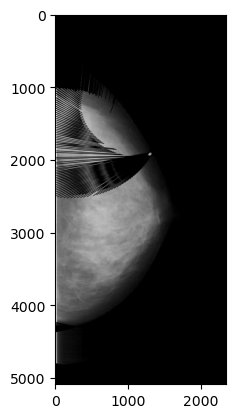

In [157]:
for line in houghline:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    print(x1,y1)
    # if data[y1, x1] > 200:
        # continue
    cv2.line(data, (x1, y1), (x2, y2), (0, 0, 0), 5,cv2.LINE_AA)
plt.imshow(data,cmap='gray')

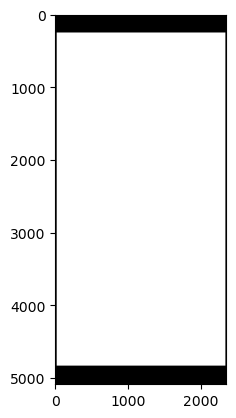

In [54]:
border_y = int(0.05*data.shape[0])
border_x = int(0.01*data.shape[1])
rect = cv2.rectangle(img=np.zeros((data.shape),dtype='uint8'),pt1=(border_x,border_y),pt2=(data.shape[1]-border_x, data.shape[0]-border_y),color=(255,255,255),thickness=-1)
plt.imshow(rect,cmap='gray')

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomZoom(height_factor=(0,-0.5),width_factor=(0,-0.5),fill_mode='constant')
  ])

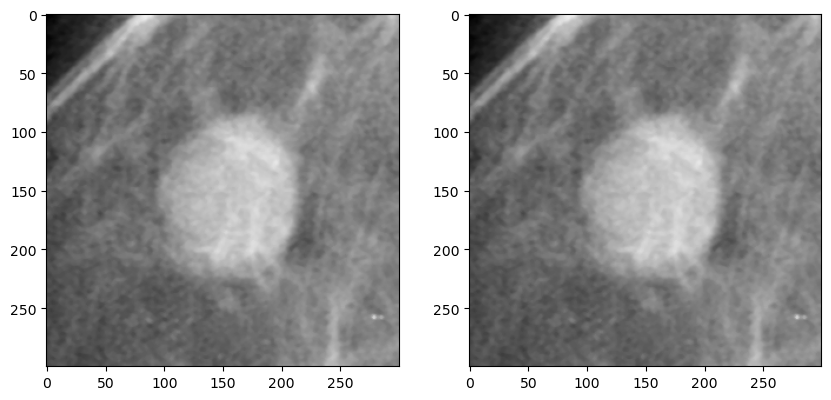

In [26]:

data = cv2.imread('/mnt/d/CBIS-DDSM/new_ROI/augmented/test/benign/Mass-Test_P_00099_LEFT_MLO_1_1.png',cv2.IMREAD_COLOR)
# testclahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(1,1))
# data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
# data = GCN(data)
# print(data.max())
gaus_data = cv2.GaussianBlur(data,(3,3),cv2.BORDER_DEFAULT)
norm_data = normalize_breast(gaus_data)
# norm_data2 = cv2.normalize(gaus_data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
norm_data2 = GCN(gaus_data)
med_data = cv2.medianBlur(norm_data,3)
med_data2 = cv2.medianBlur(norm_data2,3)
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(med_data,cmap='gray')
plt.subplot(122)
plt.imshow(med_data2,cmap='gray')


[[ 57   0   0 ...   0   0   0]
 [ 56   0   0 ...   0   0   0]
 [ 56   0   0 ...   0   0   0]
 ...
 [ 37   0   0 ... 109 110 110]
 [ 38   0   0 ... 108 108 108]
 [ 43   0   0 ... 108 108 108]]


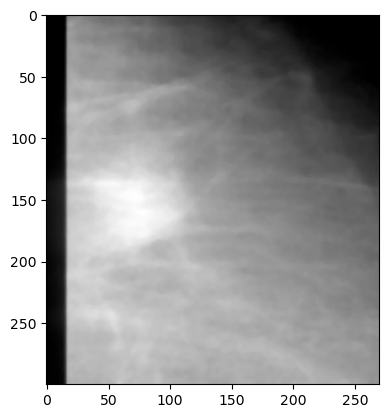

In [24]:
data = cv2.imread('/mnt/d/CBIS-DDSM/new_ROI/augmented/train/malignant/Mass-Training_P_01445_RIGHT_CC_1_1.png',cv2.IMREAD_GRAYSCALE)
print(data)
ret,thresh = cv2.threshold(data,10,255,cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contours = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(largest_contours)
    img_contour = np.zeros(data.shape,np.uint8)
    plt.imshow(cv2.drawContours(img_contour, [largest_contours], -1, 255, -1))
    if w>50 and h>50:
        data = data[y:y+h,x:x+w]
ret,thresh = cv2.threshold(data,200,255,cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contours = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(largest_contours)
    img_contour = np.zeros(data.shape,np.uint8)
    plt.imshow(cv2.drawContours(img_contour, [largest_contours], -1, 255, -1))
    if w< data.shape[1]/2:
        if x+w == data.shape[1]:
            data = data[:,:data.shape[1]-w]
        elif x == 0:
            data = data[:,w:]
    if h< data.shape[0]/2:
        if y+h == data.shape[0]:
            data = data[:data.shape[1]-h,:]
        elif y == 0:
            data = data[h:,:]
# data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
plt.imshow(data,cmap='gray')

In [28]:
def global_contrast_normalization(image, scale=1.0, subtract_mean=True, use_std=True, sqrt_bias=1e-6):
    """
    Apply global contrast normalization to an image.
    Args:
        image (numpy.ndarray): input image.
        scale (float): scaling factor for normalized values.
        subtract_mean (bool): whether to subtract mean of image values.
        use_std (bool): whether to divide by standard deviation of image values.
        sqrt_bias (float): factor to prevent division by zero.
    Returns:
        numpy.ndarray: normalized image.
    """
    if subtract_mean:
        image = image - np.mean(image)

    if use_std:
        image = image / np.sqrt(np.var(image) + sqrt_bias)

    return scale * image

296
8


True

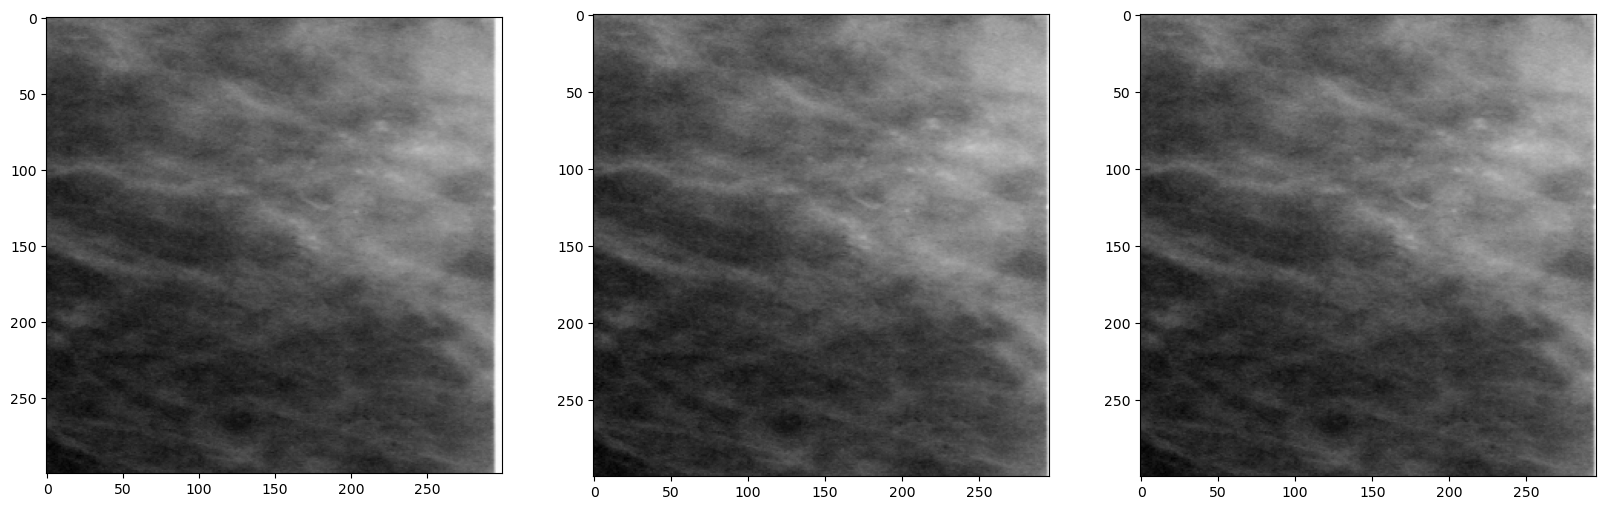

In [52]:
plt.figure(figsize=(20,60))
data = cv2.imread('/mnt/d/Datasets/CBIS-DDSM/ROI/augmented/train/malignant/P_01198_RIGHT_CC_1_1.png', cv2.IMREAD_GRAYSCALE)
plt.subplot(131)
plt.imshow(data,cmap='gray')
# data = global_contrast_normalization(data,scale=1,sqrt_bias=10,use_std=True)
# print(data)
ret,thresh = cv2.threshold(data,250,255,0)
contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# print(contours)
if contours:
  # cnt = contours[-1]
  largest_contours = max(contours, key=cv2.contourArea)
  x,y,w,h = cv2.boundingRect(largest_contours)
  print(x)
  # img = cv2.drawContours(data,[cnt],0,(255,255,255),2)
#   if w>10 and h>10:
  if x+w == data.shape[1]:
    data = data[:,:data.shape[1]-w]
  # elif x-w == 0:
    # data = data[y:y+h,w:]
# data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
# print(data.min())
plt.subplot(132)
plt.imshow(data,cmap='gray')
# data = np.interp(data,(data.min(),data.max()),(0,255)).astype(dtype=np.uint8)
print(data.min())
# testclahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(1,1))
data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
# data = testclahe.apply(data)
plt.subplot(133)
plt.imshow(data,cmap='gray')
cv2.imwrite('/mnt/d/Datasets/CBIS-DDSM/testing1.png',data)

In [59]:
np.where(img_id == "523cdecbef6f4fa9ec4c49ead52846ba" )

(array([2094, 2095]),)

(3580, 2812)


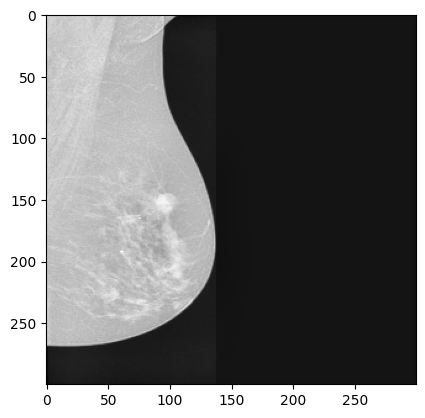

In [58]:
data = pydicom.dcmread(imgPATH+"afa015c6fcf47f108939c6663af44990/523cdecbef6f4fa9ec4c49ead52846ba.dicom")
# data = pydicom.dcmread(imgPATH+filename[0]+'/'+img_id[0]+".data")
data = data.pixel_array.astype(float)
data = (np.maximum(data,0)/data.max())*255.0

data = np.uint8(data)
# # # data = cv2.medianBlur(data,3)
# data = np.invert(data)
print(data.shape)

# data = data[int(mask_y_min[20140]):int(mask_y_max[20140]),int(mask_x_min[20140]):int(mask_x_max[20140])]
data = clahe.apply(data)
data = cv2.resize(data,(300,300))
plt.imshow(data, cmap="gray")

# cv2.imwrite(PATH+"test.png",data)

In [21]:
from preprocess import DMImagePreprocessor
preprocess = DMImagePreprocessor()

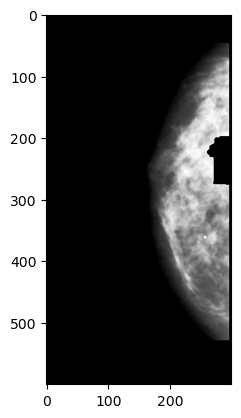

In [32]:
img = cv2.imread('/mnt/d/Datasets/CBIS-DDSM/full_mammogram_image/augmented/train/malignant/Calc-Training_P_00855_RIGHT_CC.png',cv2.IMREAD_GRAYSCALE)                      
image,mask = preprocess.process(img=img, median_filtering=True, blur_kn_size=3, 
                                artif_suppression=True, low_int_threshold=.05, kernel_size=15,
                                pect_removal=False, high_int_threshold=.8)

plt.imshow(mask,cmap='gray')

In [2]:
import simple_load_data as loaddata
import random
from collections import defaultdict, Counter

In [3]:
train,test = loaddata.load_all_files()

In [6]:
groups = np.array(train[2]['new_labels'].values)
groups

array([3, 3, 1, ..., 2, 2, 2], dtype=uint8)

In [7]:
folds = loaddata.divide_into_k_folds(train[2],k=5)


In [8]:
train_set = []
for fold in folds[:-1]:
    for indice in fold:
        train_set.append(indice)
val_set = folds[-1]



In [9]:
for i in train_set:
    if i in val_set:
        print(i)

In [10]:
print(len(test[1]))

653


In [20]:
test_img = []
test_label = []
for i in range(len(test[1])):
    if test[1][i] == 0 or test[1][i] ==2:
        test_img.append(test[0][i])
        test_label.append(test[1][i])

In [21]:
0 in test[1]

True

In [94]:
train_img = []
train_label = []
for i in train_set:
    if train[1][i] == 0 or train[1][i] ==2:
        train_img.append(train[0][i])
        train_label.append(train[1][i])
val_img = []
val_label = []
for i in val_set:
    if train[1][i] == 0 or train[1][i] ==2:
        val_img.append(train[0][i])
        val_label.append(train[1][i])
print(len(train_img))

955


In [105]:
save_path = '/mnt/d/CBIS_DDSM_Patch/png/train/'
i=0
for labels in train_label:
    img = train_img[i]
    img = cv2.resize(img,(300,300))
    if labels == 0:
        malignancy = 'benign/'
    elif labels == 2:
        malignancy = 'malignant/'
    cv2.imwrite(save_path + malignancy + str(i+1)+'.png', img)
    i+=1


In [106]:
save_path = '/mnt/d/CBIS_DDSM_Patch/png/val/'
i=0
for labels in val_label:
    img = val_img[i]
    img = cv2.resize(img,(300,300))
    if labels == 0:
        malignancy = 'benign/'
    elif labels == 2:
        malignancy = 'malignant/'
    cv2.imwrite(save_path + malignancy + str(i+1)+'.png', img)
    i+=1












In [ ]:
save_path = '/mnt/d/CBIS_DDSM_Patch/png/test/'
i=0
for labels in test_label:
    img = test_img[i]
    img = cv2.resize(img,(300,300))
    if labels == 0:
        malignancy = 'benign/'
    elif labels == 2:
        malignancy = 'malignant/'
    cv2.imwrite(save_path + malignancy + str(i+1)+'.png', img)
    i+=1


In [ ]:
if not os.path.exists(directory):
    os.makedirs(directory)

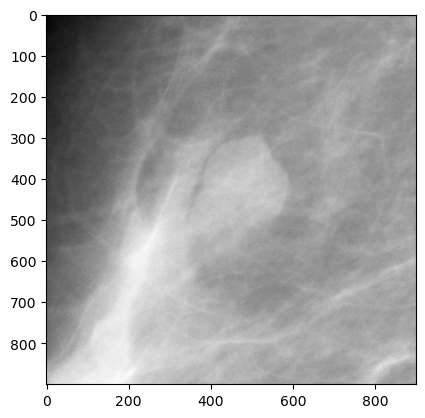

In [92]:
plt.imshow(train_img[5],cmap='gray')

In [69]:
print(len(train_set))

1788


In [72]:
folds

[array([  17,   18,   26,   27,   28,   29,   30,   31,   47,   48,   55,
          56,   59,   60,   63,   64,   65,   72,   81,   87,   88,   89,
          90,   96,   97,  113,  114,  126,  127,  132,  133,  134,  135,
         138,  139,  140,  141,  142,  143,  144,  155,  156,  161,  162,
         163,  164,  165,  171,  172,  208,  213,  214,  217,  218,  219,
         221,  222,  225,  226,  232,  233,  243,  244,  258,  259,  292,
         293,  308,  309,  331,  332,  337,  362,  363,  366,  367,  380,
         381,  387,  388,  389,  390,  395,  403,  404,  417,  418,  419,
         420,  422,  423,  433,  434,  437,  438,  449,  450,  459,  460,
         461,  462,  472,  487,  488,  499,  500,  505,  506,  508,  509,
         510,  511,  515,  516,  517,  520,  521,  530,  533,  534,  535,
         537,  538,  558,  559,  570,  571,  579,  581,  582,  585,  586,
         595,  598,  599,  602,  603,  624,  625,  628,  629,  630,  631,
         646,  647,  648,  655,  656, 

In [50]:
for x in train[1]:
    print(x)

3
3
1
1
1
1
3
3
1
3
3
1
1
3
3
1
1
1
1
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
1
1
1
3
3
1
1
3
3
1
3
3
3
3
3
3
1
1
3
3
1
1
3
3
1
1
1
1
3
3
3
1
3
3
3
3
3
1
3
3
1
1
1
1
1
1
1
1
1
3
3
3
1
1
1
1
3
1
1
1
1
1
1
1
1
3
3
3
3
1
1
3
3
1
1
1
1
3
3
3
3
3
1
1
1
1
3
3
1
3
3
1
1
3
3
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
3
3
1
1
1
1
3
3
1
3
3
1
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
1
1
1
3
3
3
3
3
3
3
1
1
3
3
3
3
1
1
1
1
1
1
1
3
3
1
1
3
3
3
3
3
3
3
3
1
1
1
3
3
1
1
1
1
1
1
1
1
3
3
3
3
3
1
1
3
3
3
3
3
3
3
3
3
1
1
1
1
1
1
3
3
3
1
1
1
1
1
1
1
3
3
3
3
3
1
1
3
3
3
3
1
1
3
1
1
3
1
1
1
1
3
3
3
3
1
1
1
3
1
3
3
3
3
3
1
1
1
1
1
1
1
1
3
3
1
3
3
1
1
1
1
1
1
1
3
3
1
1
3
3
3
3
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
3
3
3
3
3
3
3
3
1
1
1
1
1
1
3
3
1
1
1
1
1
3
3
3
3
3
3
3
3
1
1
1
1
3
3
3
3
1
1
1
1
1
1
3
3
3
3
3
3
3
3
1
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
1
1
3
3
1
1
1
1
3
3
1
1
3
3
1
1
3
3
1
1
3
3
1
1
3
3
3
3
3
3
1
1
1
1
1
1
1
1
3
3
3
3
1
1
1
1
1
1
1
3
1
1
3
3
1
1
3
3
3
3
3
3
3
1
3
1
1
1
3


In [43]:
train_set = []
for i in folds[:4]:
    print(train[1].shape)
    


(2233,)
(2233,)
(2233,)
(2233,)


[[167 167 167 ... 137 138 138]
 [167 166 166 ... 137 137 137]
 [166 166 166 ... 137 137 136]
 ...
 [ 66  65  65 ...  55  55  55]
 [ 68  66  66 ...  54  56  56]
 [ 68  67  65 ...  53  54  55]]


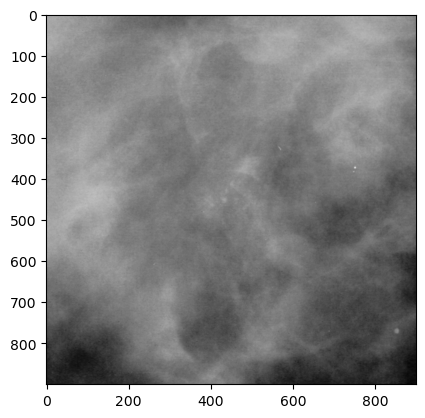

In [41]:
print(train_set[0][0][0])
plt.imshow(train_set[0][0][0],cmap='gray')